
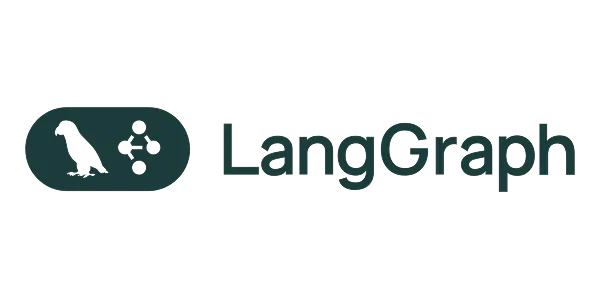



## Building a Conditional State Graph with LangGraph - Part-2


**Definition:**  
A **conditional graph state** allows a workflow to dynamically decide which node to execute next based on the current state or output of a node. It introduces **decision-making logic** into the graph, similar to an "if-else" structure in programming.

---

## Key Points:

1. **Dynamic Routing**  
   - Conditional states allow the workflow to **branch to different nodes** depending on specific conditions in the state.  
   - Example: If the agent determines a question requires a tool, it routes to the tool node; otherwise, it goes directly to a response node.

2. **Flexibility & Adaptability**  
   - Enables the graph to handle **multiple scenarios** without hardcoding linear sequences.  
   - Supports **complex workflows** with varying paths for different user inputs.

3. **Modular Design**  
   - Each node performs a distinct function.  
   - Conditional edges control how the **output of one node influences the next**, making it easy to extend or modify workflows.

4. **Implementation in Language Graph:**  
   - Use `add_conditional_edges()` to define routing logic.  
   - The function evaluates the current state and returns the **next node dynamically**.  
   - The graph continues execution along the chosen path.

6. **Why Conditional States are Important:**  
   - Real-world tasks and conversations are **not linear**.  
   - Conditional states make workflows **intelligent, adaptive, and efficient**, avoiding the need for multiple separate graphs.

---

## Example

*This diagram shows a generalized conditional workflow for a customer support system, where the intent detection node dynamically routes the query to the appropriate handler.*

```mermaid
graph TD
    Start["Start"]
    IntentNode["Intent Detection Node"]
    BillingNode["Billing Support Node"]
    TechNode["Technical Support Node"]
    FAQNode["FAQ Response Node"]
    ResponseNode["Response Node"]

    Start --> IntentNode
    IntentNode -->|Billing Query| BillingNode
    IntentNode -->|Technical Query| TechNode
    IntentNode -->|General Query| FAQNode
    BillingNode --> ResponseNode
    TechNode --> ResponseNode
    FAQNode --> ResponseNode
    ResponseNode --> END
```


## Exercise

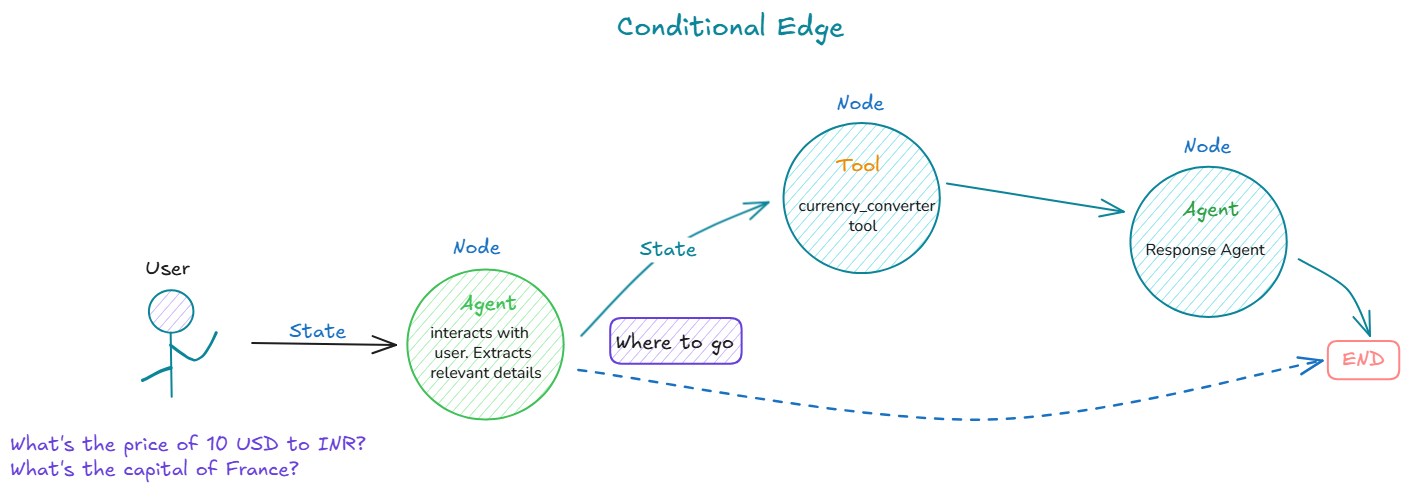

In [ ]:

# Install required packages
!pip install -U langgraph graphviz langchain_google_genai langchain


## Imports

In [5]:

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

# For visualization
from IPython.display import Image, display
import graphviz



**1. API Key**


In [3]:
import os

os.environ["GOOGLE_API_KEY"] = "Your-api-key"

**2. Initialize Gemini LLM**

In [6]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

**3. Define State**

In [7]:
from typing import TypedDict

class ChatState(TypedDict):
    message: str
    response: str

**4. Define Nodes**

In [12]:
# --- Node 1: Agent ---
def agent_node(state: dict) -> dict:
    """
    Agent checks if it's a currency conversion query.
    If yes, extracts amount/from_cur/to_cur as plain text.
    """
    prompt = ChatPromptTemplate.from_template("""
    The user said: "{question}".

    - If it's a currency conversion, extract:
      - amount (number)
      - from currency (3-letter code)
      - to currency (3-letter code)

    Reply in this format ONLY:
    amount=<number>, from=<FROM>, to=<TO>

    - If it's NOT a conversion, reply:
    no_tool=<your natural response>
    """)
    chain = prompt | llm
    output = chain.invoke({"question": state["message"]}).content.strip()

    if output.startswith("amount="):
        parts = dict(item.split("=") for item in output.split(", "))
        return {
            "message": state["message"],
            "response": "USE_TOOL",
            "amount": float(parts["amount"]),
            "from_cur": parts["from"],
            "to_cur": parts["to"],
        }
    else:
        return {"message": state["message"], "response": output.replace("no_tool=", "").strip()}

# --- Node 2: ConvertCurrency tool ---
def convert_currency(state: dict) -> dict:
    """Dynamic currency conversion using Frankfurter API."""
    amount = state.get("amount", 1.0)
    from_cur = state.get("from_cur")
    to_cur = state.get("to_cur")

    url = f"https://api.frankfurter.app/latest?amount={amount}&from={from_cur}&to={to_cur}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        rate = list(data["rates"].values())[0]
        raw_response = f"{amount} {from_cur} = {rate:.2f} {to_cur}"
    else:
        raw_response = "Error fetching conversion rate."

    return {"message": state["message"], "response": raw_response}


def response_agent_node(state: dict) -> dict:
    """Refines the response from currency_tool into human-readable text."""
    prompt_text = f"""
    Here is a currency conversion result: '{state['response']}'.
    Please convert it into a clear, human-readable sentence.
    """
    refined_response = llm.invoke(prompt_text).content.strip()
    return {"message": state["message"], "response": refined_response}

In [13]:
# import requests
# from_cur = 'USD'
# to_cur = 'INR'
# amount = 1
# url = f"https://api.frankfurter.app/latest?amount={amount}&from={from_cur}&to={to_cur}"
# response = requests.get(url)

In [11]:
# response.json()

{'amount': 1.0, 'base': 'USD', 'date': '2025-09-19', 'rates': {'INR': 88.16}}

**5. Build Graph**

In [14]:
# --- Build the Graph ---
workflow = StateGraph(dict)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("convert_currency_tool", convert_currency)
workflow.add_node("response_agent", response_agent_node)


# Conditional routing function
def route_condition(state: dict) -> str:
    if state["response"] == "USE_TOOL":
        return "convert_currency_tool"
    else:
        return END   # <-- use END constant, not "__end__"

# Conditional edges (agent can go either to currency_tool or END)
workflow.add_conditional_edges(
    "agent",
    route_condition,
    {
        "convert_currency_tool": "convert_currency_tool",
        END: END,
    }
)


# Normal edges
workflow.add_edge("convert_currency_tool", "response_agent")
workflow.add_edge("response_agent", END)

# Set entry point
workflow.set_entry_point("agent")

# Compile
app = workflow.compile()

**6 Show Graph Structure**

In [15]:
from IPython.display import display, Markdown

# Get the Mermaid code
mermaid_code = app.get_graph().draw_mermaid()

# Display in Jupyter
display(Markdown(f"```mermaid\n{mermaid_code}\n```"))


```mermaid
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	convert_currency_tool(convert_currency_tool)
	response_agent(response_agent)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	agent -.-> __end__;
	agent -.-> convert_currency_tool;
	convert_currency_tool --> response_agent;
	response_agent --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

```

**7. Run the graph**

In [16]:
inputs = {"message": "What's the price of 10 USD to INR?"}
print(app.invoke(inputs))

{'message': "What's the price of 10 USD to INR?", 'response': 'Ten US dollars is equal to 881.60 Indian rupees.'}


In [17]:
inputs = {"message": "Hey, i want to know the price of 8 US dollar to indian rupees"}
print(app.invoke(inputs))

{'message': 'Hey, i want to know the price of 8 US dollar to indian rupees', 'response': '8 US dollars is equal to 705.28 Indian rupees.'}


In [18]:
inputs = {"message": "Hey,Whats the capital of India?"}
print(app.invoke(inputs))

{'message': 'Hey,Whats the capital of India?', 'response': 'The capital of India is New Delhi.'}


In [19]:
inputs = {"message": "Hey, Whats your thought on the agentic AI using Langgraph?"}
print(app.invoke(inputs))

{'message': 'Hey, Whats your thought on the agentic AI using Langgraph?', 'response': "I don't have thoughts or opinions as I am an AI.  I can tell you that LangGraph is a knowledge graph technology that could potentially be used to build agentic AI systems, but I don't have access to specific details about any such projects."}


# Summary: Conditional Graph State in LangGraph

- Conditional graph states allow a workflow to **decide dynamically** which node to execute next.  
- They introduce **if-else like logic** in the graph.  
- Useful for **handling multiple scenarios** in a single workflow.  
- Supports **modular design**, where each node performs a specific task.  
- Enables **intelligent, adaptive, and scalable workflows**, closer to real-world processes.  
- Example: A chatbot can route queries to **billing, technical support, or FAQ nodes** based on the detected intent.  
- Visualized using **conditional edges** showing decision-based paths between nodes.
